In [7]:
!nrnivmodl /home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod
from neuron import h
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from neuron.units import ms, mV
import plotly.io as pio
from matplotlib import pyplot, cm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
from neuron import clear_gui_callback
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from numpy.linalg import pinv, eig
import numpy as np
from multiprocessing import Pool
font2={'family':'Times New Roman',
'weight':'bold',
'size': 10}
# 自定义刻度标签显示格式


h.load_file('nrngui.hoc')
h.load_file("import3d.hoc")

morphologyFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/morphologies/cell1.asc"
biophysicalModelFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCbiophys1.hoc"
biophysicalModelTemplateFilename = "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/models/L5PCtemplate.hoc"

h.load_file(biophysicalModelFilename)
h.load_file(biophysicalModelTemplateFilename)
import sys
sys.path.append('/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron')
from common_function import exp_fitting, plot_curve

/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron
Mod files: "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/CaDynamics_E2.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_HVA.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ca_LVAst.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/epsp.mod" "/home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod//home/wzl/LFPy/project/conductance_measurement/realistic_neuron/L5PC_neuron/L5PC/mod/Ih.

In [8]:
def est_GL_C(run_dt, passive=True, block='', name= ''):
   
    L5PC = h.L5PCtemplate(morphologyFilename)
    # L5PC.soma[0].L = 0.001
    print(L5PC.soma[0].L)
    
    # L5PC.soma[0].L = 0.001
    
    if passive:
        for sec in h.allsec():
            # 检查 section 是否有主动离子通道
            if h.ismembrane("na3", sec=sec):
                # 将电导设置为0
                sec.gbar_na3 = 0.
            if h.ismembrane("h", sec=sec):
                sec.ghdbar_h = 0.
            if h.ismembrane("kadist", sec=sec):
                sec.gkabar_kadist = 0.
            if h.ismembrane("kaprox", sec=sec):
                sec.gkabar_kaprox = 0.
            if h.ismembrane("kdrca1", sec=sec):
                sec.gkdrbar_kdrca1 = 0.
            if h.ismembrane("nax", sec=sec):
                sec.gbar_nax = 0.
            if h.ismembrane("Ca_HVA",sec=sec):
                sec.gCa_HVAbar_Ca_HVA = 0.
            if h.ismembrane("Ca_LVAst",sec=sec):
                sec.gCa_LVAstbar_Ca_LVAst = 0.
            if h.ismembrane("Ih",sec=sec):
                sec.gIhbar_Ih = 0.
            if h.ismembrane("Im",sec=sec):
                sec.gImbar_Im = 0.
            if h.ismembrane("K_Pst",sec=sec):
                sec.gK_Pstbar_K_Pst = 0.
            if h.ismembrane("K_Tst",sec=sec):
                sec.gK_Tstbar_K_Tst = 0.
            if h.ismembrane("Nap_Et2",sec=sec):
                sec.gNap_Et2bar_Nap_Et2 = 0.
            if h.ismembrane("NaTa_t",sec=sec):
                sec.gNaTa_tbar_NaTa_t = 0.
            if h.ismembrane("NaTs2_t",sec=sec):
                sec.gNaTs2_tbar_NaTs2_t = 0.
            if h.ismembrane("SK_E2",sec=sec):
                sec.gSK_E2bar_SK_E2 = 0.
            if h.ismembrane("SKv3_1",sec=sec):
                sec.gSKv3_1bar_SKv3_1 = 0.   
    
    if block:
        for sec in h.allsec():
            if h.ismembrane(block, sec=sec):
                # 将电导设置为0
                setattr(sec, name, 0.)
        
    h.dt = run_dt
    h.tstop = 2000.
    h.v_init = -90.
    time = h.Vector().record(h._ref_t)
    recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)
    

    # Initialize voltage clamp
    iclamp = h.IClamp(L5PC.soma[0](0.5))
    iclamp.delay = 100.
    iclamp.dur = 1000.
    iclamp.amp = 0.
    
    i_clamp = h.Vector().record(iclamp._ref_i)

    # Function to initialize the simulation
    def initialize():
        h.t = 0
        h.finitialize(h.v_init)
        h.fcurrent()

    # Function to integrate the simulation
    def integrate():
        while h.t < h.tstop:
            h.fadvance()

    # Function to run the simulation
    def go():
        initialize()
        integrate()
        
    def verfication(GL, C, t, I):
        
        v = np.zeros(len(t))
        for i in range(len(t)-1):
            v[i+1] = v[i] + run_dt/C*(-GL*v[i]+I[i])
            
        return v
        
        
    # Main simulation loop
    def main():
    
        i_amp = np.arange(1,20)*0.004
        C = np.zeros(len(i_amp))
        GL = np.zeros(len(i_amp))
        V_peak = np.zeros(len(i_amp))
        iclamp.amp = 0.
        go()
        recv0 = np.array(recv.to_python())
        V_rest = recv0[-1]
        print(V_rest)
        
        for i in range(len(i_amp)):      
            iclamp.amp = i_amp[i]
            go()
            recv0 = np.array(recv.to_python())
            i0 = np.array(i_clamp.to_python())
            time0 = np.array(time.to_python())
            plt.plot(time0, recv0-V_rest, color='r',label='neuron')
            recv_norm = recv0 - V_rest
            GL[i] = i_amp[i]*1e-3/recv_norm[10000]
            
            y = np.log(recv_norm[11000:])
            A = np.ones((len(time0[11000:]),2))
            A[:,0] = time0[11000:] - time0[11000]
            x, residuals, rank, singular_values = np.linalg.lstsq(A, y, rcond=None)
            tau_decay = -1./x[0] 
            C[i] = tau_decay*GL[i]
            v = verfication(GL[i], C[i], time0, i0*1e-3)
            # v_tune = verfication(0.011, 0.31, time0, i0)
            plt.plot(time0, v, 'b', label='point')
            # plt.plot(time0, v_tune, 'k', label=f'i_amp[i]_tune')
            plt.legend()
        return  GL,C
    
    GL,C = main()
    return  GL,C

23.169408032474415
-90.0
1.1765184264270517e-05
0.0004926353606097049


/home/wzl/anaconda/envs/nest/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


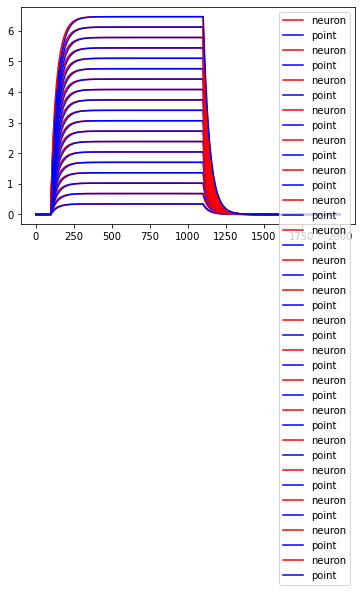

In [9]:
GL,C = est_GL_C(0.1, passive=True, block='',name= '')
print(np.mean(GL))
print(np.mean(C))

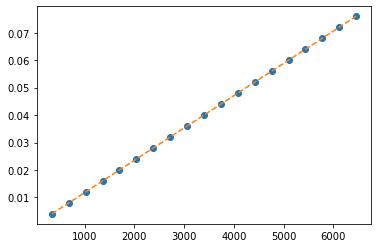

In [12]:
i_amp = np.arange(1,20)*0.004
V_peak = i_amp/GL
plt.plot(V_peak,i_amp, 'o')
plt.plot(V_peak, np.mean(GL)*V_peak, '--')


# validate the point neuron

0.001


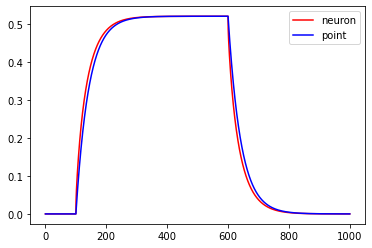

In [6]:
GL0 = np.mean(GL)
C0 = np.mean(C)
passive = True
run_dt = 0.1
V_rest = -90.

L5PC = h.L5PCtemplate(morphologyFilename)
L5PC.soma[0].L = 0.001
print(L5PC.soma[0].L)

if passive:
    for sec in h.allsec():
        # 检查 section 是否有主动离子通道
        if h.ismembrane("na3", sec=sec):
            # 将电导设置为0
            sec.gbar_na3 = 0.
        if h.ismembrane("h", sec=sec):
            sec.ghdbar_h = 0.
        if h.ismembrane("kadist", sec=sec):
            sec.gkabar_kadist = 0.
        if h.ismembrane("kaprox", sec=sec):
            sec.gkabar_kaprox = 0.
        if h.ismembrane("kdrca1", sec=sec):
            sec.gkdrbar_kdrca1 = 0.
        if h.ismembrane("nax", sec=sec):
            sec.gbar_nax = 0.
        if h.ismembrane("Ca_HVA",sec=sec):
            sec.gCa_HVAbar_Ca_HVA = 0.
        if h.ismembrane("Ca_LVAst",sec=sec):
            sec.gCa_LVAstbar_Ca_LVAst = 0.
        if h.ismembrane("Ih",sec=sec):
            sec.gIhbar_Ih = 0.
        if h.ismembrane("Im",sec=sec):
            sec.gImbar_Im = 0.
        if h.ismembrane("K_Pst",sec=sec):
            sec.gK_Pstbar_K_Pst = 0.
        if h.ismembrane("K_Tst",sec=sec):
            sec.gK_Tstbar_K_Tst = 0.
        if h.ismembrane("Nap_Et2",sec=sec):
            sec.gNap_Et2bar_Nap_Et2 = 0.
        if h.ismembrane("NaTa_t",sec=sec):
            sec.gNaTa_tbar_NaTa_t = 0.
        if h.ismembrane("NaTs2_t",sec=sec):
            sec.gNaTs2_tbar_NaTs2_t = 0.
        if h.ismembrane("SK_E2",sec=sec):
            sec.gSK_E2bar_SK_E2 = 0.
        if h.ismembrane("SKv3_1",sec=sec):
            sec.gSKv3_1bar_SKv3_1 = 0.   
h.dt = run_dt
h.tstop = 1000.
h.v_init = -90.
time = h.Vector().record(h._ref_t)
recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)


# Initialize voltage clamp
iclamp = h.IClamp(L5PC.soma[0](0.5))
iclamp.delay = 100.
iclamp.dur = 500.
iclamp.amp = 0.

i_clamp = h.Vector().record(iclamp._ref_i)

# Function to initialize the simulation
def initialize():
    h.t = 0
    h.finitialize(h.v_init)
    h.fcurrent()

# Function to integrate the simulation
def integrate():
    while h.t < h.tstop:
        h.fadvance()

# Function to run the simulation
def go():
    initialize()
    integrate()
    
def verfication(GL, C, t, I):
    
    v = np.zeros(len(t))
    for i in range(len(t)-1):
        v[i+1] = v[i] + run_dt/C*(-GL*v[i]+I[i])
        
    return v
    
    


i_amp = 0.004*1.5
iclamp.amp = i_amp
go()
recv0 = np.array(recv.to_python())
i0 = np.array(i_clamp.to_python())
time0 = np.array(time.to_python())
plt.plot(time0, recv0-V_rest, color='r',label='neuron')
v = verfication(GL0, C0, time0, i0)
plt.plot(time0, v, 'b', label='point')
plt.legend()

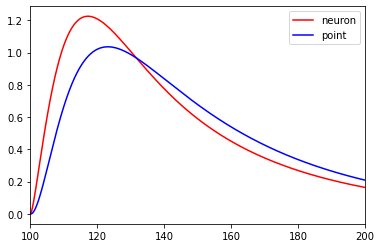

In [9]:
GL0 = np.mean(GL)
C0 = np.mean(C)
passive = True
run_dt = 0.1
V_rest = -90.
fE = 0.5*1e-3

L5PC = h.L5PCtemplate(morphologyFilename)
L5PC.soma[0].L = 0.001

if passive:
    for sec in h.allsec():
        # 检查 section 是否有主动离子通道
        if h.ismembrane("na3", sec=sec):
            # 将电导设置为0
            sec.gbar_na3 = 0.
        if h.ismembrane("h", sec=sec):
            sec.ghdbar_h = 0.
        if h.ismembrane("kadist", sec=sec):
            sec.gkabar_kadist = 0.
        if h.ismembrane("kaprox", sec=sec):
            sec.gkabar_kaprox = 0.
        if h.ismembrane("kdrca1", sec=sec):
            sec.gkdrbar_kdrca1 = 0.
        if h.ismembrane("nax", sec=sec):
            sec.gbar_nax = 0.
        if h.ismembrane("Ca_HVA",sec=sec):
            sec.gCa_HVAbar_Ca_HVA = 0.
        if h.ismembrane("Ca_LVAst",sec=sec):
            sec.gCa_LVAstbar_Ca_LVAst = 0.
        if h.ismembrane("Ih",sec=sec):
            sec.gIhbar_Ih = 0.
        if h.ismembrane("Im",sec=sec):
            sec.gImbar_Im = 0.
        if h.ismembrane("K_Pst",sec=sec):
            sec.gK_Pstbar_K_Pst = 0.
        if h.ismembrane("K_Tst",sec=sec):
            sec.gK_Tstbar_K_Tst = 0.
        if h.ismembrane("Nap_Et2",sec=sec):
            sec.gNap_Et2bar_Nap_Et2 = 0.
        if h.ismembrane("NaTa_t",sec=sec):
            sec.gNaTa_tbar_NaTa_t = 0.
        if h.ismembrane("NaTs2_t",sec=sec):
            sec.gNaTs2_tbar_NaTs2_t = 0.
        if h.ismembrane("SK_E2",sec=sec):
            sec.gSK_E2bar_SK_E2 = 0.
        if h.ismembrane("SKv3_1",sec=sec):
            sec.gSKv3_1bar_SKv3_1 = 0.   
h.dt = run_dt
h.tstop = 200.
h.v_init = -90.
time = h.Vector().record(h._ref_t)
recv = h.Vector().record(L5PC.soma[0](0.5)._ref_v)

# Initialize an excitatory and inhibitory synaptic input
# make a new stimulator
stimE = h.NetStim()
synE = h.Exp2Syn(L5PC.soma[0](0.5))
synE.tau1 = 5.  # ms
synE.tau2 = 8.  # ms
synE.e = 0.  # mV for E input and -80 for I input 
Isyn_local = h.Vector().record(synE._ref_i)
    
stimE.number = 1
stimE.start = 100.  # ms
ncstimE = h.NetCon(stimE, synE)
ncstimE.delay = 0.
ncstimE.weight[0] = fE  # uS



# Function to initialize the simulation
def initialize():
    h.t = 0
    h.finitialize(h.v_init)
    h.fcurrent()

# Function to integrate the simulation
def integrate():
    while h.t < h.tstop:
        h.fadvance()

# Function to run the simulation
def go():
    initialize()
    integrate()
    
def verfication(GL, C, t, I):
    
    v = np.zeros(len(t))
    for i in range(len(t)-1):
        v[i+1] = v[i] + run_dt/C*(-GL*v[i]+I[i])
        
    return v
    
    
go()
recv0 = np.array(recv.to_python())
i0 = np.array(Isyn_local.to_python())
time0 = np.array(time.to_python())
plt.plot(time0, recv0-V_rest, color='r',label='neuron')
v = verfication(GL0, C0, time0,-i0)
plt.plot(time0, v, 'b', label='point')
plt.xlim([100,200])
plt.legend()

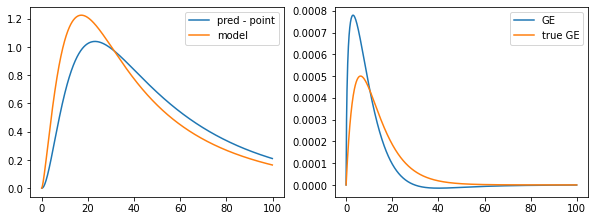

In [10]:
fig, ax2 = plt.subplots(1,2, figsize = (10,3.5))
# C0 = np.mean(C)
# GL0 = np.mean(GL)
time= np.arange(0,1000)*0.1
V = np.zeros(len(time))
epsilonE = 0 - V_rest
uE = np.exp(-time/8.)-np.exp(-time/5.)
NE = ((5./8.)**(5./3.)-(5./8.)**(8./3.))**(-1)
recvE_norm = recv0 - V_rest
for i in range(len(V)-1):
    V[i+1] = V[i] + 0.1/C0*(-GL0*V[i] - fE*NE*uE[i]*(V[i]-epsilonE) )
ax2[0].plot(time,V,label='pred - point')
ax2[0].plot(time,recvE_norm[1001:], label='model')
ax2[0].legend()

true_GE = fE*NE*uE
dvdt = np.diff(recvE_norm)/run_dt
dvdt = np.append(dvdt,0)
GE_eff = (C0*dvdt + GL0*recvE_norm)/(epsilonE - recvE_norm)
ax2[1].plot(time, GE_eff[1000:-1],label='GE')
ax2[1].plot(time,true_GE,label='true GE')
ax2[1].legend()